# Import Libraries

In [5]:
#Import libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Define custom dataset class

In [6]:
class RetrofitDataset(Dataset):
    def __init__(self, data, targets):
        # Convert data and target into PyTorch tensors and store them
        self.data = torch.tensor(data, dtype=torch.float32)
        self.targets = [torch.tensor(t, dtype=torch.float32) for t in targets]

    def __len__(self):
        # Return the size of the dataset
        return len(self.data)

    def __getitem__(self, idx):
        # Get the feature vector and corresponding targets for a given index
        x = self.data[idx]
        y = [t[idx] for t in self.targets]
        return x, y

In [4]:
# Load the CSV file
file_path = r'C:\Users\isabella.lucchese\Desktop\Graduation\Excel sheets\Inputs\Input Amin gives me for MTL\merged_output_SC_2024.csv'
df = pd.read_csv(file_path)

# Define the columns that are static and should be kept the same for each building
static_columns = [
    'Building ID', 'index', '2025-01-01', 'meestvoorkomendepostcode', 'function', 'building_type', 'age_range',
    'height', 'area', 'perimeter', 'average_wwr', 'windows_U_Factor', 'windows_Solar_Heat_Gain_Coefficient',
    'groundfloor_roughness', 'groundfloor_thickness', 'groundfloor_conductivity', 'groundfloor_density',
    'groundfloor_specific_heat', 'groundfloor_thermal_absorptance', 'groundfloor_solar_absorptance',
    'groundfloor_visible_absorptance', 'groundfloor_thermal_resistance', 'ext_walls_roughness', 'ext_walls_thickness',
    'ext_walls_conductivity', 'ext_walls_density', 'ext_walls_specific_heat', 'ext_walls_thermal_absorptance',
    'ext_walls_solar_absorptance', 'ext_walls_visible_absorptance', 'ext_walls_thermal_resistance', 'roof_roughness',
    'roof_thickness', 'roof_conductivity', 'roof_density', 'roof_specific_heat', 'roof_thermal_absorptance',
    'roof_solar_absorptance', 'roof_visible_absorptance', 'roof_thermal_resistance', 'int_walls_roughness',
    'int_walls_thickness', 'int_walls_conductivity', 'int_walls_density', 'int_walls_specific_heat',
    'int_walls_thermal_absorptance', 'int_walls_solar_absorptance', 'int_walls_visible_absorptance',
    'int_walls_thermal_resistance', 'int_floors_roughness', 'int_floors_thickness', 'int_floors_conductivity',
    'int_floors_density', 'int_floors_specific_heat', 'int_floors_thermal_absorptance', 'int_floors_solar_absorptance',
    'int_floors_visible_absorptance', 'int_floors_thermal_resistance'
]

# Columns corresponding to daily values (which should be summed to get annual consumption)
date_columns = [col for col in df.columns if col.startswith('2024-')]

# Group by 'Building ID' and process the data for annual energy consumption
annual_data = []

for building_id, group in df.groupby('Building ID'):
    # Extract rows for energy types, handling missing rows
    electricity_building = group[group['index'].str.contains('Electricity Building')].iloc[0] if not group[group['index'].str.contains('Electricity Building')].empty else None
    electricity_facility = group[group['index'].str.contains('Electricity Facility')].iloc[0] if not group[group['index'].str.contains('Electricity Facility')].empty else None
    gas_consumption = group[group['index'].str.contains('Gas Consumption')].iloc[0] if not group[group['index'].str.contains('Gas Consumption')].empty else None

    # If all energy rows exist, calculate the annual sum
    if electricity_building is not None and electricity_facility is not None and gas_consumption is not None:
        # Create a new row for the building's annual energy consumption
        annual_sum = electricity_building.copy()
        annual_sum['index'] = 'Annual Energy Consumption'
        
        # Sum the values across all daily columns (2024-01-01 to 2024-12-31)
        annual_sum_total = (electricity_building[date_columns].sum() + 
                            electricity_facility[date_columns].sum() + 
                            gas_consumption[date_columns].sum())
        
        # Keep only static columns and a new column for the total annual energy consumption
        annual_row = {col: electricity_building[col] for col in static_columns}  # Copy static values
        annual_row['Annual Energy Consumption [J]'] = annual_sum_total
        
        annual_data.append(annual_row)

# Create a new dataframe with the annual energy consumption data
annual_df = pd.DataFrame(annual_data)

# Save the processed dataset to a new CSV file
new_file_path = r'C:\Users\isabella.lucchese\Desktop\Graduation\Excel sheets\Inputs\Input Amin gives me for MTL\annual_energy_consumption.csv'
annual_df.to_csv(new_file_path, index=False)

print(f"New dataset with annual energy consumption saved to {new_file_path}")



PermissionError: [Errno 13] Permission denied: 'C:\\Users\\isabella.lucchese\\Desktop\\Graduation\\Excel sheets\\Inputs\\Input Amin gives me for MTL\\annual_energy_consumption.csv'

# Load and preprocess data

In [7]:
# Load data from CSV file into a Pandas DataFrame
def load_data(file_path=r"C:\Users\isabella.lucchese\Desktop\Graduation\Excel sheets\Inputs\Input Amin gives me for MTL\annual_energy_consumption.csv"):
    data = pd.read_csv(file_path)
    return data


# Preprocess the data for MTL
def preprocess_data(data):
    # Extract Features (X)
    X = data[['windows_U_Factor', 'groundfloor_thermal_resistance', 'ext_walls_thermal_resistance', 'roof_thermal_resistance']].select_dtypes(include='number')
    
    # replace NaN with 0
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

    # 1. COST CALCULATION
    def calculate_window_cost(windows_U_Factor):
        if windows_U_Factor == 2.7:
            return 0
        elif windows_U_Factor == 1.0:
            return 184
        elif windows_U_Factor == 1.6:
            return 485
        elif windows_U_Factor == 1.2:
            return 295
        elif windows_U_Factor == 1.5:
            return 622
        else:
            return 0  # Default

    def calculate_floor_cost(groundfloor_thickness):
        if groundfloor_thickness == 0.08:
            return 59.7
        elif groundfloor_thickness == 0.09:
            return 77
        elif groundfloor_thickness == 0.1:
            return 87.9
        elif groundfloor_thickness == 0.13:
            return 108
        else:
            return 0

    def calculate_facade_cost(ext_walls_thickness):
        if ext_walls_thickness == 0.05:
            return 182
        elif ext_walls_thickness == 0.1:
            return 179
        elif ext_walls_thickness == 0.13:
            return 200
        elif ext_walls_thickness == 0.21:
            return 222
        else:
            return 0

    def calculate_roof_cost(roof_thickness):
        if roof_thickness == 0.08:
            return 89.5
        elif roof_thickness == 0.11:
            return 105
        elif roof_thickness == 0.185:
            return 101
        elif roof_thickness == 0.23:
            return 139
        else:
            return 0

    # Calculate total cost
    def calculate_total_cost(row):
        window_cost = calculate_window_cost(row['windows_U_Factor'])
        floor_cost = calculate_floor_cost(row['groundfloor_thermal_resistance'])
        facade_cost = calculate_facade_cost(row['ext_walls_thermal_resistance'])
        roof_cost = calculate_roof_cost(row['roof_thermal_resistance'])
        return window_cost + floor_cost + facade_cost + roof_cost

    # Apply cost calculation
    data['Total_Cost'] = data.apply(calculate_total_cost, axis=1)

    # 2. CARBON CALCULATION
    def calculate_window_carbon(windows_U_Factor):
        if windows_U_Factor == 2.7:
            return 0
        elif windows_U_Factor == 1.0:
            return 70
        elif windows_U_Factor == 1.6:
            return 50
        elif windows_U_Factor == 1.2:
            return 150
        elif windows_U_Factor == 1.5:
            return 120
        else:
            return 0

    def calculate_floor_carbon(groundfloor_thickness):
        if groundfloor_thickness == 0.08:
            return 10
        elif groundfloor_thickness == 0.09:
            return 6
        elif groundfloor_thickness == 0.1:
            return 11
        elif groundfloor_thickness == 0.13:
            return 7
        else:
            return 0

    def calculate_facade_carbon(ext_walls_thickness):
        if ext_walls_thickness == 0.05:
            return 9
        elif ext_walls_thickness == 0.1:
            return 5
        elif ext_walls_thickness == 0.13:
            return 17
        elif ext_walls_thickness == 0.21:
            return 9
        else:
            return 0

    def calculate_roof_carbon(roof_thickness):
        if roof_thickness == 0.08:
            return 23
        elif roof_thickness == 0.11:
            return 5
        elif roof_thickness == 0.185:
            return 18
        elif roof_thickness == 0.23:
            return 11
        else:
            return 0

    # Calculate total carbon
    def calculate_total_carbon(row):
        window_carbon = calculate_window_carbon(row['windows_U_Factor'])
        floor_carbon = calculate_floor_carbon(row['groundfloor_thermal_resistance'])
        facade_carbon = calculate_facade_carbon(row['ext_walls_thermal_resistance'])
        roof_carbon = calculate_roof_carbon(row['roof_thermal_resistance'])
        return window_carbon + floor_carbon + facade_carbon + roof_carbon

    # Apply carbon calculation
    data['Total_Carbon'] = data.apply(calculate_total_carbon, axis=1)




    # 3. ENERGY CONSUMPTION CALCULATION
    data['Energy_Consumption'] = data['Annual Energy Consumption [J]'].fillna(0)





    # # PRINT THE CALCULATIONS FOR THE 3 TASKS
    # for building_id in data['Building ID'].unique():
    #     building_data = data[data['Building ID'] == building_id]
    #     print(f"\nBuilding ID: {building_id}")

    #     if building_data.empty:
    #         print(f"No data for Building ID: {building_id}")
    #         continue

    #     # Print energy consumption datafor the building
    #     energy_consumption_value = building_data['Energy_Consumption'].values[0] if 'Energy_Consumption' in building_data.columns else 0
    #     print(f"\nEnergy Consumption: {energy_consumption_value}")

    #     # Check and print the total cost for the building
    #     if 'Total_Cost' in building_data.columns and not building_data['Total_Cost'].isna().all():
    #         total_cost = building_data['Total_Cost'].values[0]
    #         print(f"\nTotal Cost for Building: {total_cost}")
    #     else:
    #         print("\nNo cost data available for this building.")

    #     # Check and print the total carbon emissions for the building
    #     if 'Total_Carbon' in building_data.columns and not building_data['Total_Carbon'].isna().all():
    #         total_carbon = building_data['Total_Carbon'].values[0]
    #         print(f"Total Carbon Emissions for Building: {total_carbon}")
    #     else:
    #         print("\nNo carbon data available for this building.")

        

    # DEFINE THE TARGET VARIABLES (y)
    y = {
        'Total_Cost': data['Total_Cost'].values,
        'Total_Carbon': data['Total_Carbon'].values,
        'Energy_Consumption': data['Energy_Consumption'].values
    }

    # FEATURE AND TARGET NORMALIZATION
    # Normalize the features (X)
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)

    # Normalize numeric target variables (skip Indoor_Comfort as it is binary)
    scalers_y = {key: StandardScaler() for key in y if key != 'Indoor_Comfort'}
    y_scaled = {key: scalers_y[key].fit_transform(y[key].reshape(-1, 1)) for key in y if key != 'Indoor_Comfort'}



    # ADD TO DEAL WITH NAN
    print("Mean and standard deviation of scaled features:")
    print(np.mean(X_scaled), np.std(X_scaled))

    for key, value in y_scaled.items():
        print(f"Mean and standard deviation of target '{key}':")
        print(np.mean(value), np.std(value))


    return X, y_scaled, scalers_y, y

# Load and preprocess the data
data = load_data()
# Preprocess data
X, y_scaled, scalers_y, y = preprocess_data(data)


Mean and standard deviation of scaled features:
-1.5255286745775298e-16 0.49999999999999983
Mean and standard deviation of target 'Total_Cost':
1.1403772302322596e-16 1.0
Mean and standard deviation of target 'Total_Carbon':
4.386066270124075e-17 0.9999999999999999
Mean and standard deviation of target 'Energy_Consumption':
-3.4649923533980193e-16 0.9999999999999999


In [8]:
data


,Building ID,index,2025-01-01,meestvoorkomendepostcode,function,building_type,age_range,height,area,perimeter,...,int_floors_density,int_floors_specific_heat,int_floors_thermal_absorptance,int_floors_solar_absorptance,int_floors_visible_absorptance,int_floors_thermal_resistance,Annual Energy Consumption [J],Total_Cost,Total_Carbon,Energy_Consumption
0,17000000.0,Building 17000000: Electricity Building [J](Da...,4.054158e+08,4921AH,Residential,Apartment,1975 - 1991,7.4,162.0,53.0,...,32.0,1400.0,0.9,0.7,0.7,1.15,1.024608e+13,0,0,1.024608e+13
1,17000001.0,Building 17000001: Electricity Building [J](Da...,4.054158e+08,4921AH,Residential,Apartment,1975 - 1991,7.4,162.0,53.0,...,32.0,1400.0,0.9,0.7,0.7,1.15,1.026034e+13,0,0,1.026034e+13
2,17000002.0,Building 17000002: Electricity Building [J](Da...,4.054158e+08,4921AH,Residential,Apartment,1975 - 1991,7.4,162.0,53.0,...,32.0,1400.0,0.9,0.7,0.7,1.15,1.025381e+13,0,0,1.025381e+13
3,17000003.0,Building 17000003: Electricity Building [J](Da...,4.054158e+08,4921AH,Residential,Apartment,1975 - 1991,7.4,162.0,53.0,...,32.0,1400.0,0.9,0.7,0.7,1.15,1.024089e+13,0,0,1.024089e+13
4,17000004.0,Building 17000004: Electricity Building [J](Da...,4.035657e+08,4921AH,Residential,Apartment,1975 - 1991,7.4,162.0,53.0,...,32.0,1400.0,0.9,0.7,0.7,1.15,1.163268e+13,0,0,1.163268e+13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3235,17003235.0,Building 17003235: Electricity Building [J](Da...,4.031641e+08,4921AH,Residential,Apartment,1975 - 1991,7.4,162.0,53.0,...,32.0,1400.0,0.9,0.7,0.7,1.15,8.925970e+12,184,70,8.925970e+12
3236,17003236.0,Building 17003236: Electricity Building [J](Da...,4.086058e+08,4921AH,Residential,Apartment,1975 - 1991,7.4,162.0,53.0,...,32.0,1400.0,0.9,0.7,0.7,1.15,1.029471e+13,184,70,1.029471e+13
3237,17003237.0,Building 17003237: Electricity Building [J](Da...,4.078091e+08,4921AH,Residential,Apartment,1975 - 1991,7.4,162.0,53.0,...,32.0,1400.0,0.9,0.7,0.7,1.15,1.029592e+13,184,70,1.029592e+13
3238,17003238.0,Building 17003238: Electricity Building [J](Da...,4.078091e+08,4921AH,Residential,Apartment,1975 - 1991,7.4,162.0,53.0,...,32.0,1400.0,0.9,0.7,0.7,1.15,1.029687e+13,184,70,1.029687e+13


# Define the MTL Model

In [9]:
class MultiTaskModel(nn.Module):
    def __init__(self, input_size):
        super(MultiTaskModel, self).__init__()
        
        # Define shared layers
        self.shared_fc1 = nn.Linear(input_size, 128)
        self.shared_fc2 = nn.Linear(128, 64)
        
        # Define task-specific layers for energy consumption
        self.energy_fc1 = nn.Linear(64, 32)
        self.energy_out = nn.Linear(32, 1)
        
        # Define task-specific layers for carbon emissions
        self.carbon_fc1 = nn.Linear(64, 32)
        self.carbon_out = nn.Linear(32, 1)
        
        # Define task-specific layers for costs
        self.costs_fc1 = nn.Linear(64, 32)
        self.costs_out = nn.Linear(32, 1)
        
        # Define task-specific layers for internal discomfort
        #self.discomfort_fc1 = nn.Linear(64, 32)
        #self.discomfort_out = nn.Linear(32, 1)

    def forward(self, x):
        # Pass input through shared layers
        x = torch.relu(self.shared_fc1(x))
        x = torch.relu(self.shared_fc2(x))
        
        # Pass shared representation through each task-specific head
        energy = torch.relu(self.energy_fc1(x))
        energy = self.energy_out(energy)
        
        carbon = torch.relu(self.carbon_fc1(x))
        carbon = self.carbon_out(carbon)
        
        costs = torch.relu(self.costs_fc1(x))
        costs = self.costs_out(costs)
        
    #    discomfort = torch.relu(self.discomfort_fc1(x))
     #   discomfort = self.discomfort_out(discomfort)
        
        # Return the outputs for all tasks
        return energy, carbon, costs
    
        #add when comofrt
        #return energy, carbon, costs, discomfort

# Example
#input_size = X.shape[1]  # Number of input features
#model = MultiTaskModel(input_size)  # Initialize the model


# Define the loss function and optimizer

In [10]:
# Define the loss function and optimizer
def custom_loss_fn(predictions, targets, task_weights =10.0):
    # Unpack predictions and targets
    energy_pred, carbon_pred, cost_pred = predictions
    energy_target, carbon_target, cost_target = targets
    
    #add when add comfort
    #energy_pred, carbon_pred, cost_pred, comfort_pred = predictions
    #energy_target, carbon_target, cost_target, comfort_target = targets

    # Ensure that comfort_target is of type float32 to match MSELoss expectations
    #comfort_target = comfort_target.float()

    # Loss for energy, cost, and carbon (regression tasks)
    loss_energy = nn.MSELoss()(energy_pred, energy_target) * task_weights[0]
    loss_carbon = nn.MSELoss()(carbon_pred, carbon_target) * task_weights[1]
    loss_cost = nn.MSELoss()(cost_pred, cost_target) * task_weights[2]

    # Use MSELoss for indoor comfort (regression task now)
    #comfort_loss = nn.MSELoss()(comfort_pred, comfort_target) * task_weights[3]

    # Penalize false predictions for indoor comfort (optional: can remove if not needed)
    #false_penalty = ((comfort_pred < 0.5) & (comfort_target == 1.0)).float().sum() * indoor_comfort_weight

    # Total loss is the sum of all losses
    total_loss = loss_energy + loss_carbon + loss_cost #+ comfort_loss + false_penalty
    return total_loss




def get_optimizer(model, lr=1e-4):
    return optim.Adam(model.parameters(), lr=lr)




# Train the model

In [11]:
def train_model(model, dataloader, val_loader, optimizer, num_epochs=100, device='cuda', task_weights=None, indoor_comfort_weight=10.0):
    # Default task weights if none are provided
    if task_weights is None:
        task_weights = [1.0, 1.0, 1.0] # Modify based on importance of tasks
        # change  when comfort 
        # task_weights = [1.0, 1.0, 1.0, 1.0]  

    # Move the model to the specified device (GPU or CPU)
    model = model.to(device)
    
    # Lists to store loss values
    train_losses = []
    val_losses = []
    
    # Debugging: Check if there are NaN or Inf values in the dataloader
    for batch in dataloader:
        X_batch, y_batch = batch
        if torch.isnan(X_batch).any() or torch.isinf(X_batch).any():
            print("Warning: Found NaN or Inf values in input features")
        for target in y_batch:
            if torch.isnan(target).any() or torch.isinf(target).any():
                print("Warning: Found NaN or Inf values in target values")
        break  # Check the first batch to avoid slowing down training

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for batch in dataloader:
            X_batch, y_batch = batch
            X_batch = X_batch.to(device)
            y_batch = [target.to(device).unsqueeze(1) for target in y_batch]
            
            optimizer.zero_grad()
            
            # Forward pass
            predictions = model(X_batch)
            
            # Compute individual task losses for debugging
            loss_energy = nn.MSELoss()(predictions[0], y_batch[0])
            loss_carbon = nn.MSELoss()(predictions[1], y_batch[1])
            loss_cost = nn.MSELoss()(predictions[2], y_batch[2])
            #loss_comfort = nn.MSELoss()(predictions[3], y_batch[3])

            # Sum up the total loss for debugging
            total_loss_batch = loss_energy.item() + loss_carbon.item() + loss_cost.item()
            print(f"Epoch {epoch+1}, Batch Losses -> Energy: {loss_energy.item()}, Carbon: {loss_carbon.item()}, Cost: {loss_cost.item()}")

            # change when comfort
            # total_loss_batch = loss_energy.item() + loss_carbon.item() + loss_cost.item() + loss_comfort.item()
            # print(f"Epoch {epoch+1}, Batch Losses -> Energy: {loss_energy.item()}, Carbon: {loss_carbon.item()}, Cost: {loss_cost.item()}, Comfort: {loss_comfort.item()}")

            # Compute custom total loss
            loss = custom_loss_fn(predictions, y_batch, task_weights)
            # change when comfort
            # loss = custom_loss_fn(predictions, y_batch, task_weights, indoor_comfort_weight)
            loss.backward()

            # Clip gradients to avoid exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            
            total_loss += loss.item()
        
        avg_train_loss = total_loss / len(dataloader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_batch in val_loader:
                X_val, y_val = val_batch
                X_val = X_val.to(device)
                y_val = [target.to(device).unsqueeze(1) for target in y_val]
                
                val_predictions = model(X_val)
                
                # Compute validation loss
                val_loss += custom_loss_fn(val_predictions, y_val, task_weights).item()
                #change when comofrt
                #val_loss += custom_loss_fn(val_predictions, y_val, task_weights, indoor_comfort_weight).item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')

    return train_losses, val_losses





# Evaluate the model

In [12]:
# Evaluate the model
def evaluate_model(model, dataloader, loss_fn, device='cuda', task_weights=None, indoor_comfort_weight=10.0):
    if task_weights is None:
        task_weights = [1.5, 1.0, 1.0] # Provide default task weights if not specified
        #change when comfort
        # task_weights = [1.5, 1.0, 1.0, 1.0]  
    
    model.eval()  
    model = model.to(device)
    total_loss = 0
    
    with torch.no_grad():
        for batch in dataloader:
            X_batch, y_batch = batch
            X_batch = X_batch.to(device)
            y_batch = [target.to(device).unsqueeze(1) for target in y_batch]
            
            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch, task_weights)
            # change when comfort
            # loss = loss_fn(predictions, y_batch, task_weights, indoor_comfort_weight)
            total_loss += loss.item()
    
    print(f'Evaluation Loss: {total_loss/len(dataloader)}')


# Save and load the model

In [13]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model, path):
    model.load_state_dict(torch.load(path))
    return model



# Main execution and running the pipeline

In [16]:
# Load and preprocess data
data = load_data()
X, y_scaled, scalers_y, y = preprocess_data(data)

## Inspect the shapes of X and y_scaled
print("Shape of features (X):", X.shape)
for key, value in y_scaled.items():
    print(f"Shape of target '{key}':", value.shape)


# Define custom dataset class
class RetrofitDataset(Dataset):
    def __init__(self, data, targets):
        # Convert the features (data) from DataFrame to NumPy and then to Tensor
        self.data = torch.tensor(data.to_numpy(), dtype=torch.float32)

        # Convert the targets (y) from whatever they are into Tensors, ensuring they are properly reshaped
        self.targets = [torch.tensor(target.flatten(), dtype=torch.float32) for target in targets.values()]

        # Ensure that number of samples matches between data and targets
        assert len(self.data) == len(self.targets[0]), "Number of samples in features and targets must match"

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = [target[idx] for target in self.targets]
        return x, y


# Create dataset and dataloaders
dataset = RetrofitDataset(X, y_scaled)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Build, compile, and train the model
input_size = X.shape[1]  # Number of input features
model = MultiTaskModel(input_size)  # Initialize the model
optimizer = get_optimizer(model)  # Get the optimizer

# Define the task weights and indoor comfort penalty
task_weights = [1.5, 1.0, 1.0] 
#change when comfort
# #task_weights = [1.5, 1.0, 1.0, 1.0] # Adjust based on priority for tasks
#indoor_comfort_weight = 20.0  # Strong penalty for incorrect indoor comfort

# Train the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_losses, val_losses = train_model(model, train_loader, val_loader, optimizer, num_epochs=100, device=device, task_weights=task_weights)
#change when comfort
#train_losses, val_losses = train_model(model, train_loader, val_loader, optimizer, num_epochs=100, device=device, task_weights=task_weights, indoor_comfort_weight=indoor_comfort_weight)
# Evaluate the model on the validation set
evaluate_model(model, val_loader, custom_loss_fn, device=device)

# Save the trained model
save_model(model, 'mtl_retrofit_model.pth')

# Load the model and make predictions on new data
model = load_model(MultiTaskModel(input_size), 'mtl_retrofit_model.pth')
model = model.to(device)
model.eval()

# Replace with actual new data (formatted similarly to the input data)
new_data = torch.tensor([[1.0, 0.09, 0.18, 0.2]], dtype=torch.float32).to(device)

with torch.no_grad():
    predictions = model(new_data)

# Inverse transform the predictions to real-world values using the correct scaler for each task
predictions_real = []
for i, (scaler_key, pred) in enumerate(zip(scalers_y.keys(), predictions)):
    if scaler_key != 'Indoor_Comfort':
        real_pred = scalers_y[scaler_key].inverse_transform(pred.cpu().numpy().flatten().reshape(-1, 1))
    else:
        real_pred = pred.cpu().numpy().flatten()
    predictions_real.append(real_pred)

# Print predictions for each task
print("Predictions (energy consumption, carbon emissions, costs, indoor comfort):")
for i, pred in enumerate(predictions_real):
    print(f"Task {i + 1} prediction: {pred.flatten()}")





Mean and standard deviation of scaled features:
-1.5255286745775298e-16 0.49999999999999983
Mean and standard deviation of target 'Total_Cost':
1.1403772302322596e-16 1.0
Mean and standard deviation of target 'Total_Carbon':
4.386066270124075e-17 0.9999999999999999
Mean and standard deviation of target 'Energy_Consumption':
-3.4649923533980193e-16 0.9999999999999999
Shape of features (X): (3240, 4)
Shape of target 'Total_Cost': (3240, 1)
Shape of target 'Total_Carbon': (3240, 1)
Shape of target 'Energy_Consumption': (3240, 1)
Epoch 1, Batch Losses -> Energy: 1.0766680240631104, Carbon: 0.8979002833366394, Cost: 0.819525420665741
Epoch 1, Batch Losses -> Energy: 0.9789193868637085, Carbon: 1.1693750619888306, Cost: 0.8764479160308838
Epoch 1, Batch Losses -> Energy: 0.8465483784675598, Carbon: 0.8623272180557251, Cost: 1.1707065105438232
Epoch 1, Batch Losses -> Energy: 1.0981826782226562, Carbon: 1.4678481817245483, Cost: 0.6119157671928406
Epoch 1, Batch Losses -> Energy: 0.9996461272

# Printing graphs

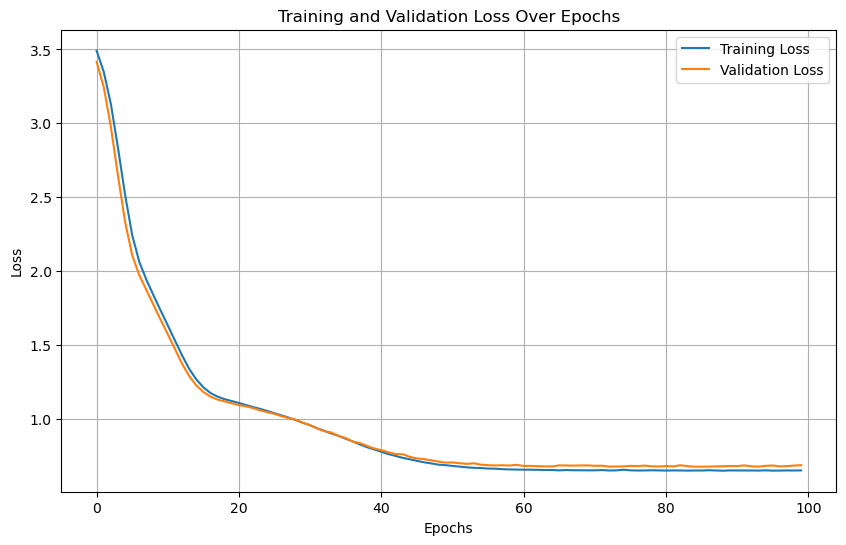

In [15]:

# Plot the training and validation loss over epochs
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


